In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['original_model','trained_model']
data_path = '../data/pose_model/groundtruth_and_predictions.pkl'
df = pd.read_pickle(data_path)

bbox_df = pd.read_pickle('../data/pose_model/bounding_box_info.pkl')

zdf_col = pd.MultiIndex.from_product([['ground_truth'], ['bbox_width', 'bbox_height']])
zdf = pd.DataFrame(columns = zdf_col)
zdf['ground_truth','bbox_width'] = bbox_df.width
zdf['ground_truth','bbox_height'] = bbox_df.height
zdf['id',''] = bbox_df.id
df = pd.merge(df,zdf, on='id', how='outer')

for i in model_names:
    df[i, 'x_square_error'] = ((df[i].x - df.ground_truth.x)/df.ground_truth.bbox_width)**2 
    df[i, 'y_square_error'] =  ((df[i].y-df.ground_truth.y)/df.ground_truth.bbox_height)**2

df = df.sort_index(axis = 1).set_index(['video', 'frame', 'id', 'part_label'])
df = df.reset_index()
df = df[~df['part_label', ''].isnull()]

In [2]:
group_by = ['video', 'frame']

def compute_metrics(df, model_names):
    precision_list = []; recall_list = []; rmse_list = [];
    relevant_elements = df.loc[~df.ground_truth.x.isnull(),:]
    for i, imodel in enumerate(model_names):
        recall =  np.sum(~relevant_elements[imodel].x.isnull())/len(relevant_elements)
        selected_items = df.loc[~df[imodel].x.isnull(),:]
        precision = np.sum(~selected_items.ground_truth.x.isnull())/len(selected_items)
        precision_list.append(precision); recall_list.append(recall)
        rmse = np.sqrt(np.nanmean(df[imodel].x_square_error.tolist() + df[imodel].y_square_error.tolist()))
        rmse_list.append(rmse)
    return pd.DataFrame.from_dict({'model': model_names, 'precision': precision_list, 'recall': recall_list, 'rmse': rmse_list})  

performance_metric_df = df.groupby(group_by).apply( lambda x: compute_metrics(x, model_names))
performance_metric_df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


model  precision    recall      rmse
video  frame                                                  
000000 000057 0  original_model   0.900000  0.529412  0.024578
              1   trained_model   0.941176  0.941176  0.055603
       000058 0  original_model   0.875000  0.411765  0.023366
              1   trained_model   0.923077  0.705882  0.035520
       000059 0  original_model   0.875000  0.411765  0.025500

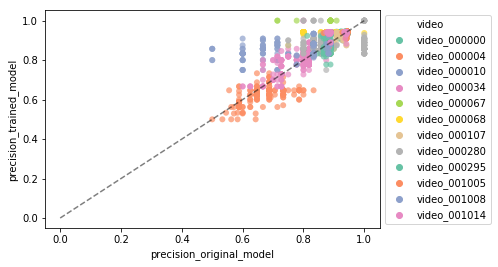

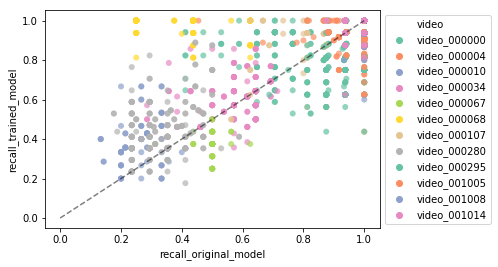

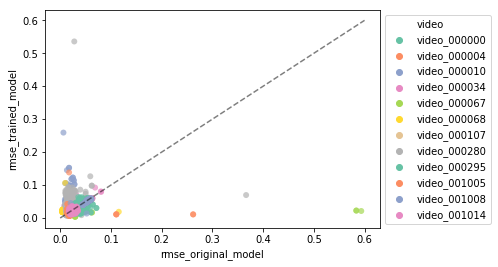

,model,precision,recall,rmse
0,original_model,0.872097,0.787174,0.038597
1,trained_model,0.881698,0.808602,0.034997


In [3]:
zdf = performance_metric_df
zdf = pd.pivot_table(zdf, values=['precision','recall', 'rmse'],\
                index=group_by, columns = 'model').reset_index()

col = ['_'.join(i).strip() for i in zdf.columns.values]
zdf = zdf.dropna()
zdf.columns = col
zdf['video'] = 'video_'+zdf['video_'].astype(str)

sns.scatterplot(data=zdf, hue='video', x='precision_original_model',\
                edgecolor='none',y='precision_trained_model', alpha=.7, palette='Set2')
plt.plot([0 ,1], [0,1], color=[0,0,0], ls='--', alpha=.5)
plt.legend(bbox_to_anchor= [1,1])
plt.show()

sns.scatterplot(data=zdf, hue='video', x='recall_original_model',\
                edgecolor='none',y='recall_trained_model', alpha=.7, palette='Set2')
plt.plot([0 ,1], [0,1], color=[0,0,0], ls='--', alpha=.5)
plt.legend(bbox_to_anchor= [1,1])
plt.show()

sns.scatterplot(data=zdf, hue='video', x='rmse_original_model',\
                edgecolor='none',y='rmse_trained_model', alpha=.7, palette='Set2')
plt.plot([0 ,.6], [0,.6], color=[0,0,0], ls='--', alpha=.5)
plt.legend(bbox_to_anchor= [1,1])
plt.show()

compute_metrics(df, model_names)